In [4]:
!pip install svgpathtools

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
    --------------------------------------- 0.5/41.0 MB 2.8 MB/s eta 0:00:15
   - -------------------------------------- 1.3/41.0 MB 3.3 MB/s eta 0:00:12
   -- ------------------------------------- 2.1/41.0 MB 3.3 MB/s eta 0:00:12
   -- ------------------------------------- 2.6/41.0 MB 3.3 MB/s eta 0:00:12
   --- ------------------------------------ 3.4/41.0 MB 3.4 MB/s eta 0:00:12
   ---- ----------------------------------- 4.2/41.0 MB 3.3 MB/s eta 0:00:12
   ---- ----------------------------------- 4.7/41.0 MB 3.3 MB/s eta 0:00:11
   ----- ---------------------------------- 5.5/41.0 MB 3.3 MB/s eta 0:00:11
   ------ --------------------------------- 6.3/41.0 MB 3.4 MB/s eta 0:00:11
   ------ --------------------------------- 6.8/41.0 MB 3.4 MB/s eta 0:00:11
   ------- -------------------------------- 7.6/41.0 MB 3.3 MB/s eta 0:00:11
   --


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import colorsys
from PIL import Image
import math
import glob


In [15]:

def extract_svg_dimensions(svg_content):
    """Extract width and height from SVG content."""
    # Try to get dimensions from viewBox
    viewbox_match = re.search(r'viewBox=["\']([\d\.\s,-]+)["\']', svg_content)
    if viewbox_match:
        viewbox = viewbox_match.group(1).split()
        if len(viewbox) >= 4:
            width = float(viewbox[2])
            height = float(viewbox[3])
            return width, height
    
    # Try to get dimensions from width and height attributes
    width_match = re.search(r'width=["\']([\d\.]+)["\']', svg_content)
    height_match = re.search(r'height=["\']([\d\.]+)["\']', svg_content)
    
    if width_match and height_match:
        width = float(width_match.group(1))
        height = float(height_match.group(1))
        return width, height
    
    # Return default if dimensions cannot be extracted
    return None, None

In [16]:


def extract_colors(svg_content):
    """Extract all colors defined in the SVG."""
    # Find all fill colors
    fill_colors = re.findall(r'fill=["\'](#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\)|[a-zA-Z]+)["\']', svg_content)
    # Find all stroke colors
    stroke_colors = re.findall(r'stroke=["\'](#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\)|[a-zA-Z]+)["\']', svg_content)
    # Find colors in style attributes
    style_colors = []
    style_matches = re.findall(r'style=["\'](.*?)["\']', svg_content)
    for style in style_matches:
        fill_in_style = re.findall(r'fill:\s*(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\)|[a-zA-Z]+)', style)
        stroke_in_style = re.findall(r'stroke:\s*(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\)|[a-zA-Z]+)', style)
        style_colors.extend(fill_in_style + stroke_in_style)
    
    # Combine all colors and filter out 'none'
    all_colors = [c for c in (fill_colors + stroke_colors + style_colors) if c.lower() != 'none']
    
    # Normalize colors to hex format when possible
    normalized_colors = []
    for color in all_colors:
        try:
            if color.startswith('#'):
                # Expand short hex notation
                if len(color) == 4:  # #RGB format
                    color = '#' + ''.join([c+c for c in color[1:]])
                normalized_colors.append(color)
            elif color.startswith('rgb'):
                # Convert rgb() format to hex
                rgb_match = re.search(r'rgb\(\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\)', color)
                if rgb_match:
                    r, g, b = map(int, rgb_match.groups())
                    normalized_colors.append(f'#{r:02x}{g:02x}{b:02x}')
            else:
                # Just add the color name
                normalized_colors.append(color)
        except Exception:
            pass  # Skip colors that can't be normalized
    
    return normalized_colors


In [17]:

def categorize_color(hex_color):
    """Categorize a hex color into one of the basic color categories."""
    try:
        # Handle named colors
        if not hex_color.startswith('#'):
            # Map common named colors to basic categories
            color_map = {
                'red': 'red', 'crimson': 'red', 'darkred': 'red', 'firebrick': 'red',
                'blue': 'blue', 'navy': 'blue', 'darkblue': 'blue', 'royalblue': 'blue',
                'green': 'green', 'darkgreen': 'green', 'forestgreen': 'green',
                'yellow': 'yellow', 'gold': 'yellow',
                'black': 'black',
                'white': 'white',
                'gray': 'gray', 'grey': 'gray', 'silver': 'gray',
                'orange': 'orange',
                'purple': 'magenta', 'magenta': 'magenta', 'violet': 'magenta',
                'brown': 'brown',
                'pink': 'pink'
            }
            
            lower_color = hex_color.lower()
            for key, value in color_map.items():
                if key in lower_color:
                    return value
            return "other"
            
        # Convert hex to RGB
        hex_color = hex_color.lstrip('#')
        if len(hex_color) == 3:
            hex_color = ''.join([c*2 for c in hex_color])
        
        if len(hex_color) < 6:
            return "unknown"
            
        r, g, b = [int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4)]
        
        # Convert RGB to HSV
        h, s, v = colorsys.rgb_to_hsv(r, g, b)
        
        # Define color categories based on HSV
        if v < 0.2:
            return "black"
        if s < 0.1 and v > 0.8:
            return "white"
        if s < 0.1:
            return "gray"
        
        # Map hue to color categories
        h_degrees = h * 360
        if 0 <= h_degrees < 30 or 330 <= h_degrees <= 360:
            return "red"
        elif 30 <= h_degrees < 90:
            return "yellow"
        elif 90 <= h_degrees < 150:
            return "green"
        elif 150 <= h_degrees < 210:
            return "cyan"
        elif 210 <= h_degrees < 270:
            return "blue"
        elif 270 <= h_degrees < 330:
            return "magenta"
        else:
            return "other"
    except Exception:
        return "unknown"


In [18]:
def count_svg_elements(svg_content):
    """Count different SVG elements used in the flag using regex instead of BeautifulSoup."""
    elements = {}
    
    for tag in ['rect', 'circle', 'path', 'polygon', 'line', 'polyline', 'ellipse', 'text']:
        # Count opening tags for each element type
        elements[tag] = len(re.findall(f'<{tag}[^>]*>', svg_content))
    
    return elements

In [19]:

def analyze_flags(directory):
    """Analyze all SVG flags in the given directory."""
    # Find all SVG files
    svg_files = glob.glob(os.path.join(directory, "*.svg"))
    
    # Initialize data containers
    data = []
    all_aspect_ratios = []
    color_counts = Counter()
    basic_color_counts = Counter()
    element_counts = defaultdict(int)
    
    for svg_file in svg_files:
        country = os.path.splitext(os.path.basename(svg_file))[0]
        
        # Read SVG content
        try:
            with open(svg_file, 'r', encoding='utf-8') as f:
                svg_content = f.read()
        except UnicodeDecodeError:
            # Try with a different encoding if utf-8 fails
            with open(svg_file, 'r', encoding='latin-1') as f:
                svg_content = f.read()
        
        # Extract dimensions
        width, height = extract_svg_dimensions(svg_content)
        aspect_ratio = None
        if width and height and height != 0:
            aspect_ratio = width / height
            all_aspect_ratios.append(aspect_ratio)
        
        # Extract colors
        colors = extract_colors(svg_content)
        unique_colors = set(colors)
        
        # Categorize colors
        basic_colors = [categorize_color(color) for color in unique_colors]
        basic_color_counts.update(basic_colors)
        
        # Count SVG elements
        elements = count_svg_elements(svg_content)
        for elem, count in elements.items():
            element_counts[elem] += count
        
        # Store flag data
        flag_data = {
            'country': country,
            'width': width,
            'height': height,
            'aspect_ratio': aspect_ratio,
            'num_colors': len(unique_colors),
            'colors': ','.join(unique_colors),
            'basic_colors': ','.join(basic_colors),
            **elements
        }
        data.append(flag_data)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    return df, all_aspect_ratios, basic_color_counts, element_counts


In [20]:
def generate_visualizations(df, aspect_ratios, color_counts, element_counts):
    """Generate visualizations based on the analysis."""
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 15))
    
    # 1. Aspect Ratio Distribution
    ax1 = fig.add_subplot(3, 2, 1)
    sns.histplot(aspect_ratios, bins=20, kde=True, ax=ax1)
    ax1.set_title('Distribution of Flag Aspect Ratios')
    ax1.set_xlabel('Aspect Ratio (width/height)')
    
    # Add vertical lines for common aspect ratios
    common_ratios = {
        '1:1': 1.0,
        '3:2': 1.5,
        '2:1': 2.0,
        '5:3': 5/3
    }
    for label, ratio in common_ratios.items():
        ax1.axvline(x=ratio, color='red', linestyle='--', alpha=0.7)
        ax1.text(ratio+0.02, ax1.get_ylim()[1]*0.9, label, rotation=90)
    
    # 2. Number of Colors Distribution
    ax2 = fig.add_subplot(3, 2, 2)
    sns.countplot(x='num_colors', data=df, ax=ax2)
    ax2.set_title('Number of Colors in Flags')
    ax2.set_xlabel('Number of Unique Colors')
    
    # 3. Basic Color Usage
    ax3 = fig.add_subplot(3, 2, 3)
    color_data = pd.Series(color_counts)
    color_data.sort_values(ascending=False).plot(kind='bar', ax=ax3)
    ax3.set_title('Basic Color Usage in Flags')
    ax3.set_xlabel('Color')
    ax3.set_ylabel('Count')
    
    # 4. SVG Element Usage
    ax4 = fig.add_subplot(3, 2, 4)
    element_data = pd.Series(element_counts)
    element_data.sort_values(ascending=False).plot(kind='bar', ax=ax4)
    ax4.set_title('SVG Element Usage in Flags')
    ax4.set_xlabel('Element Type')
    ax4.set_ylabel('Count')
    
    # 5. Aspect Ratio Categories
    ax5 = fig.add_subplot(3, 2, 5)
    # Define common aspect ratio categories
    df['aspect_ratio_category'] = pd.cut(
        df['aspect_ratio'],
        bins=[0, 1.1, 1.4, 1.6, 1.9, 2.1, float('inf')],
        labels=['Square (~1:1)', 'Between 1:1 and 3:2', '~3:2', 'Between 3:2 and 2:1', '~2:1', 'Other']
    )
    df_with_categories = df.dropna(subset=['aspect_ratio_category'])
    if not df_with_categories.empty:
        sns.countplot(y='aspect_ratio_category', data=df_with_categories, ax=ax5)
    ax5.set_title('Common Aspect Ratio Categories')
    
    # 6. Correlation between number of colors and element complexity
    ax6 = fig.add_subplot(3, 2, 6)
    df['total_elements'] = df[['rect', 'circle', 'path', 'polygon', 'line', 'polyline', 'ellipse']].sum(axis=1)
    sns.scatterplot(x='num_colors', y='total_elements', data=df, ax=ax6)
    ax6.set_title('Colors vs Element Complexity')
    ax6.set_xlabel('Number of Colors')
    ax6.set_ylabel('Total Elements')
    
    plt.tight_layout()
    plt.savefig('flag_analysis.png')
    
    # Generate additional visualizations for aspect ratios
    plt.figure(figsize=(12, 8))
    # Create a more precise histogram
    sns.histplot(aspect_ratios, bins=40, kde=True)
    plt.title('Detailed Distribution of Flag Aspect Ratios')
    plt.xlabel('Aspect Ratio (width/height)')
    
    # Add vertical lines for common aspect ratios with more details
    common_ratios = {
        '1:1 (Square)': 1.0,
        '4:3': 4/3,
        '5:4': 5/4,
        '3:2': 1.5,
        '5:3': 5/3,
        '16:9': 16/9,
        '2:1': 2.0
    }
    for label, ratio in common_ratios.items():
        plt.axvline(x=ratio, color='red', linestyle='--', alpha=0.7)
        plt.text(ratio+0.02, plt.gca().get_ylim()[1]*0.9, label, rotation=90)
    
    plt.savefig('aspect_ratio_detailed.png')
    
    return


In [21]:
def analyze_flag_proportions(aspect_ratios):
    """Analyze the mathematical properties of flag aspect ratios."""
    results = {}
    
    # Round aspect ratios to identify common fractions
    rounded_ratios = [round(ar * 100) / 100 for ar in aspect_ratios]
    ratio_counter = Counter(rounded_ratios)
    
    # Find most common aspect ratios
    results['common_ratios'] = ratio_counter.most_common(10)
    
    # Find how many flags use golden ratio (approximately)
    golden_ratio = (1 + math.sqrt(5)) / 2  # ~1.618
    golden_flags = sum(1 for ar in aspect_ratios if 1.61 <= ar <= 1.63)
    results['golden_ratio'] = golden_flags
    
    # Calculate standard deviation to see consistency
    results['std_deviation'] = np.std(aspect_ratios)
    
    # Count aspect ratios in common ranges
    results['square_flags'] = sum(1 for ar in aspect_ratios if 0.95 <= ar <= 1.05)
    results['ratio_3_2'] = sum(1 for ar in aspect_ratios if 1.45 <= ar <= 1.55)
    results['ratio_2_1'] = sum(1 for ar in aspect_ratios if 1.95 <= ar <= 2.05)
    
    return results

In [22]:
def analyze_color_combinations(df):
    """Analyze common color combinations in flags."""
    # Create a mapping of flags to their basic colors
    flag_colors = {}
    for _, row in df.iterrows():
        country = row['country']
        colors = row['basic_colors'].split(',') if isinstance(row['basic_colors'], str) else []
        flag_colors[country] = set(colors)
    
    # Analyze color combinations
    color_pairs = Counter()
    color_triplets = Counter()
    
    for country, colors in flag_colors.items():
        # Analyze pairs
        if len(colors) >= 2:
            pairs = [tuple(sorted([c1, c2])) for c1 in colors for c2 in colors if c1 < c2]
            color_pairs.update(pairs)
        
        # Analyze triplets
        if len(colors) >= 3:
            triplets = [tuple(sorted([c1, c2, c3])) 
                       for c1 in colors for c2 in colors for c3 in colors 
                       if c1 < c2 < c3]
            color_triplets.update(triplets)
    
    return {
        'color_pairs': color_pairs.most_common(10),
        'color_triplets': color_triplets.most_common(10)
    }


In [23]:
def main():
    """Main function to run the flag analysis."""
    # Directory containing SVG flags
    flag_directory = "country_flags_svg"  # Update this to your flags directory
    
    print(f"Analyzing SVG flags in {flag_directory}...")
    
    # Analyze flags
    df, aspect_ratios, color_counts, element_counts = analyze_flags(flag_directory)
    
    # Generate visualizations
    generate_visualizations(df, aspect_ratios, color_counts, element_counts)
    
    # Analyze flag proportions
    proportion_analysis = analyze_flag_proportions(aspect_ratios)
    
    # Analyze color combinations
    combination_analysis = analyze_color_combinations(df)
    
    # Save results to CSV
    df.to_csv('flag_analysis_data.csv', index=False)
    
    # Print summary of findings
    print("\n=== Flag Analysis Summary ===")
    print(f"Total flags analyzed: {len(df)}")
    print(f"Average aspect ratio: {np.mean(aspect_ratios):.3f}")
    print(f"Most common aspect ratios: {proportion_analysis['common_ratios'][:3]}")
    print(f"Flags with golden ratio: {proportion_analysis['golden_ratio']}")
    print(f"Most common colors: {color_counts.most_common(5)}")
    print(f"Most common color combinations: {combination_analysis['color_pairs'][:3]}")
    print(f"Most commonly used SVG elements: {sorted(element_counts.items(), key=lambda x: x[1], reverse=True)[:3]}")
    
    print("\nAnalysis complete. Results saved to flag_analysis_data.csv")
    print("Visualizations saved as flag_analysis.png and aspect_ratio_detailed.png")


Analyzing SVG flags in country_flags_svg...

=== Flag Analysis Summary ===
Total flags analyzed: 100
Average aspect ratio: 1.671
Most common aspect ratios: [(1.5, 37), (2.0, 31), (1.67, 11)]
Flags with golden ratio: 0
Most common colors: [('red', 153), ('yellow', 112), ('white', 85), ('green', 52), ('cyan', 49)]
Most common color combinations: [(('red', 'white'), 65), (('red', 'yellow'), 46), (('blue', 'white'), 34)]
Most commonly used SVG elements: [('path', 3068), ('ellipse', 158), ('rect', 98)]

Analysis complete. Results saved to flag_analysis_data.csv
Visualizations saved as flag_analysis.png and aspect_ratio_detailed.png


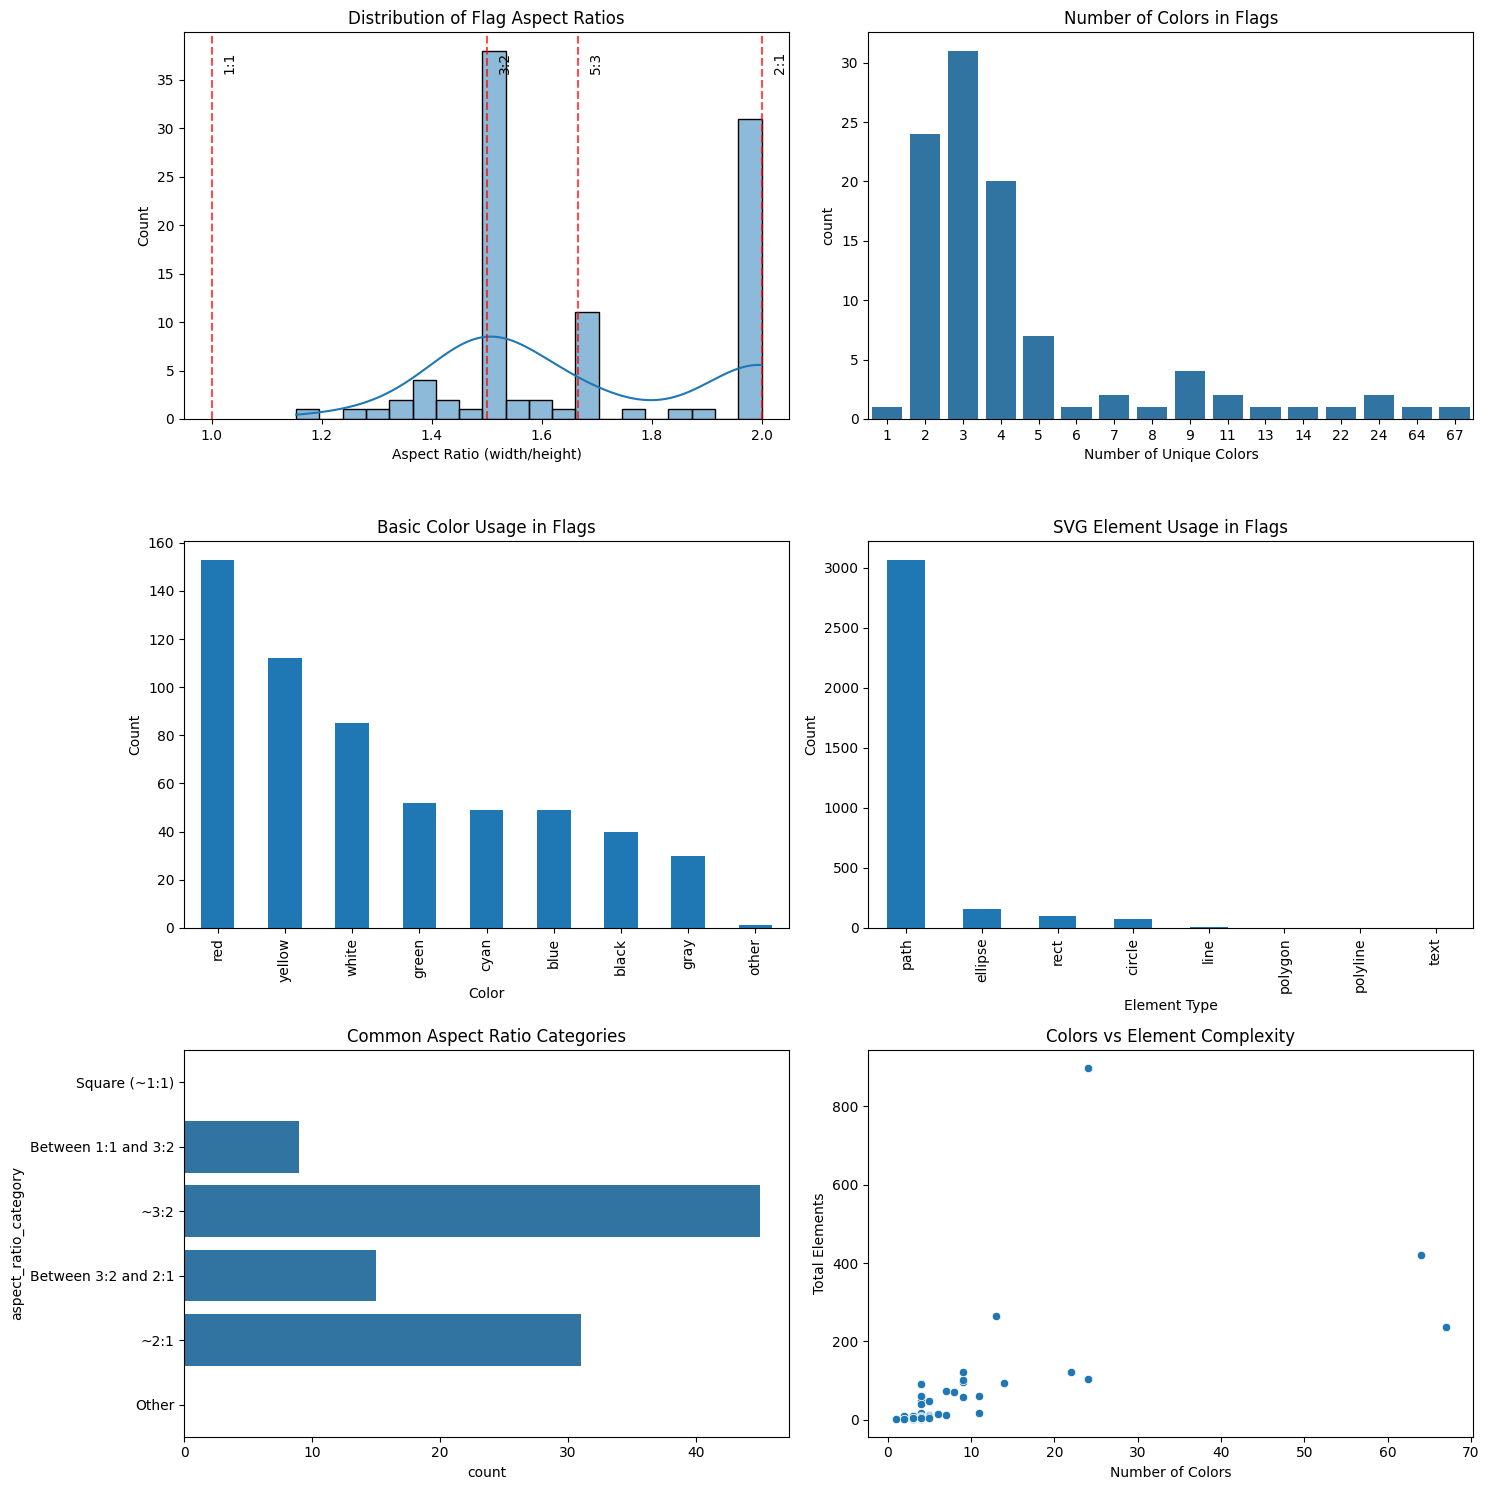

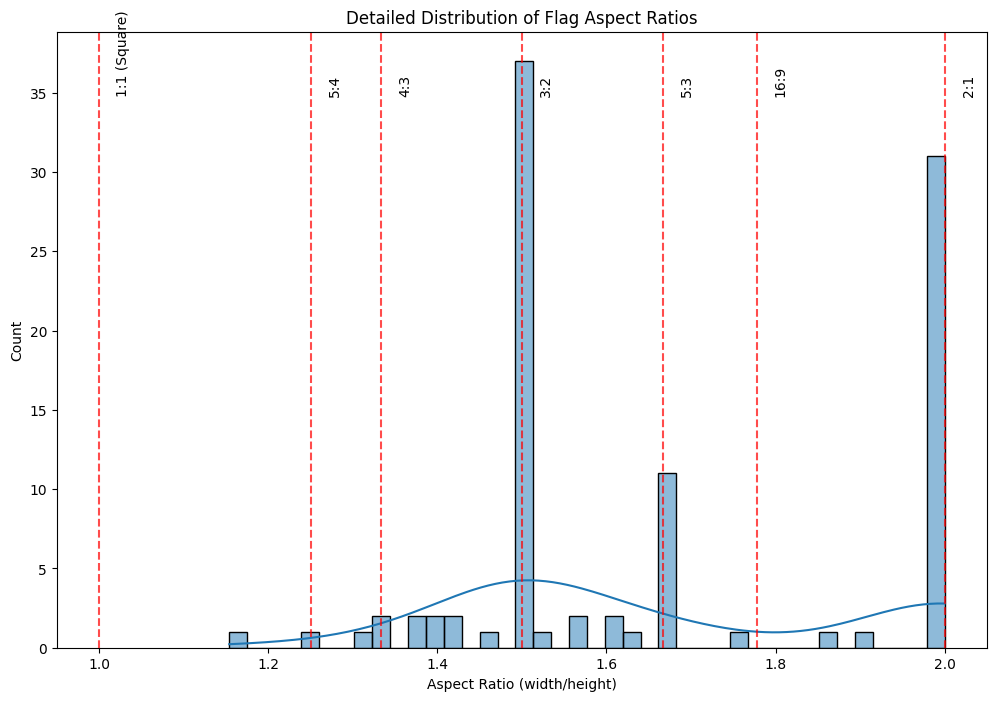

In [24]:


if __name__ == "__main__":
    main()